In [1]:
import sys
sys.path.append('../')
import numpy as np
import scipy.signal as sps
from source.reader import read_raw
from source.interference_reject import InterferenceReject
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Data import
file_name = "../data/fid_small_ecg.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(num_channels_signal)
select_channels_noise = np.arange(num_channels_signal, num_channels_all)
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

In [34]:
rej_prescan = InterferenceReject(
    use_prescan=True,
    channels_signal=select_channels_signal,
    channels_noise=select_channels_noise,
    num_freq_bins=matrix_size[0],
)
data_signal_cor = rej_prescan.apply(scan_raw=data['scan'], prescan_raw=data['noise'])
data_prescan_cor = rej_prescan.apply(scan_raw=data['noise'])

## Plot NMR lines

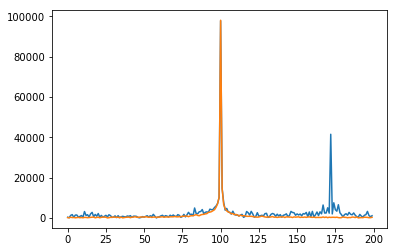

In [35]:
spec_signal_cor = np.fft.fftshift(np.fft.fft(data_signal_cor, axis=-1), axes=-1)
spec_signal_raw = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
ch = 0
plt.figure()
plt.plot(np.abs(spec_signal_raw[0, ch, :]))
plt.plot(np.abs(spec_signal_cor[0, ch, :]))
plt.show()

## Plot noise density (prescan)

Average rejection: 59.46169969047119 dB


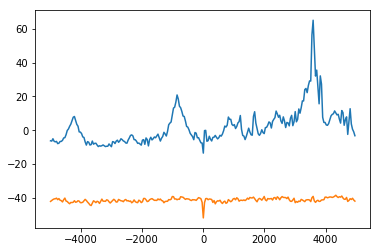

In [36]:
# Power density
noise_raw = np.transpose(data['noise'][:, :num_channels_signal, :], [0, 2, 1])
noise_cor = np.transpose(data_prescan_cor, [0, 2, 1])
nl, nr, nc = noise_raw.shape
noise_raw = np.reshape(noise_raw, [nl * nr, nc])
noise_cor = np.reshape(noise_cor, [nl * nr, nc])
freq, noise_power_raw = sps.welch(noise_raw[:, ch], fs=acq_bandwidth, return_onesided=False)
freq, noise_power_cor = sps.welch(noise_cor[:, ch], fs=acq_bandwidth, return_onesided=False)
idx_sort = np.argsort(freq)
freq = freq[idx_sort]
noise_power_cor = noise_power_cor[idx_sort]
noise_power_raw = noise_power_raw[idx_sort]
print("Average rejection: {} dB".format(10 * np.log(np.mean(noise_power_raw) / np.mean(noise_power_cor))))
plt.figure()
plt.plot(freq, 10 * np.log(noise_power_raw))
plt.plot(freq, 10 * np.log(noise_power_cor))
plt.show()

NameError: name 'coeff_all' is not defined

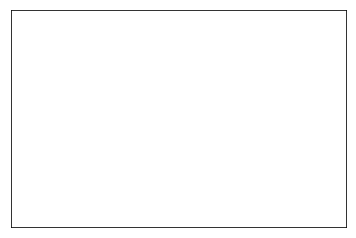

In [6]:
# Display coefficients
from matplotlib.animation import FuncAnimation
fig = plt.figure()
plt.xticks([])
plt.yticks([])
a=np.abs(coeff_all[:, :, 0])
im=plt.imshow(a,interpolation='none')

def init():
    im.set_data(np.abs(coeff_all[:, :, 0]))
    return im

# animation function.  This is called sequentially
def animate(i):
    im.set_array(np.abs(coeff_all[:, :, i]))
    return im

ani = FuncAnimation(fig, animate, frames=np.arange(142), interval=20, repeat=True,
                    init_func=init, blit=True)
plt.show()

/Users/had-mr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


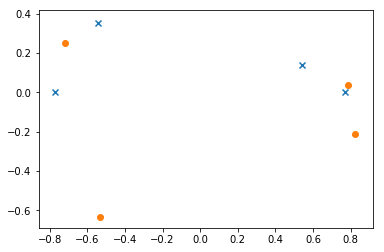

0.07307989185863745
0.07020439364021323


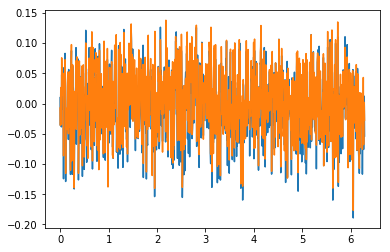

In [8]:
# Testing the coefficient fitting
tt = np.linspace(0, 2*np.pi, 1000)
s = np.exp(1j * 10 * tt)
c = np.array([0.1*np.exp(1j*np.pi*0), 0.2*np.exp(1j*np.pi*1/4), 0.5*np.exp(1j*np.pi*1), 0.5*np.exp(1j*np.pi*3/4)])
c = c[:, np.newaxis].T
r = c.T * s
s += 0.1 * np.random.random(s.shape)
n = np.random.random(r.shape) + 1j* np.random.random(r.shape)
r += 0.1*n

c_est = np.linalg.lstsq(r.T, s.T)[0]
s_est = np.dot(c_est, r)

c_inv = np.exp(-1j*np.angle(c)) / np.sum(np.abs(c))
s_inv = np.squeeze(np.dot(c_inv, r))

plt.figure()
plt.scatter(np.real(c_inv), np.imag(c), marker='x')
plt.scatter(np.real(c_est), np.imag(c_est), marker='o')
plt.show()
print(np.std(s_est - s))
print(np.std(s_inv - s))
plt.figure()
# plt.plot(tt, np.real(s))
plt.plot(tt, np.real(s_est-s))
plt.plot(tt, np.real(s_inv-s))
plt.show()
